# Import necessary packages

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import pathlib

# load dataset

###### In this example, you will train an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5,000 Electrocardiograms, each with 140 data points. It uses a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm).

In [15]:
dataframe = pd.read_csv('ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


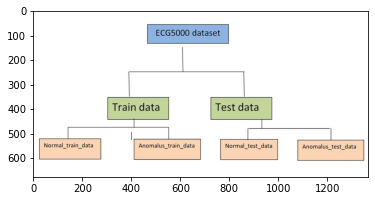

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('C:/Users/bindu/Desktop/SEM4/ICN_211/project/flow_chart.jpg')
plt.imshow(img)

### seperate labels from data  

In [3]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [4]:
print("number of training samples " + str(np.size(train_labels)))
print("number of testing samples " + str(np.size(test_labels)))

number of training samples 3998
number of testing samples 1000


### normalise data 

In [5]:
# Normalize the data to [0,1].

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [6]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

## visualise data

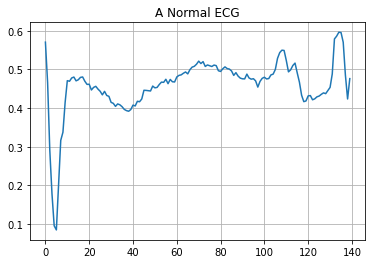

In [7]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

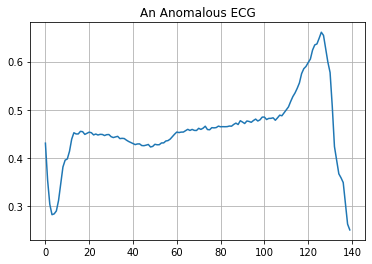

In [8]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

## Build Neural network model

In [9]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [10]:
autoencoder.compile(optimizer='adam', loss='mae')

### Train the model on normal ecg rythms

In [12]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 100ms/step - loss: 0.0580 - val_loss: 0.0529
Epoch 2/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0553 - val_loss: 0.0508
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0515 - val_loss: 0.0492
Epoch 4/20
5/5 [==============================] - ETA: 0s - loss: 0.047 - 0s 24ms/step - loss: 0.0469 - val_loss: 0.0466
Epoch 5/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0427 - val_loss: 0.0443
Epoch 6/20
5/5 [==============================] - 0s 26ms/step - loss: 0.0389 - val_loss: 0.0422
Epoch 7/20
5/5 [==============================] - 0s 25ms/step - loss: 0.0355 - val_loss: 0.0407
Epoch 8/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0328 - val_loss: 0.0397
Epoch 9/20
5/5 [==============================] - 0s 24ms/step - loss: 0.0305 - val_loss: 0.0390
Epoch 10/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0289 - val_loss: 0.0383
Epoc

In [13]:
autoencoder.summary()

Model: "anomaly_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 8)                 5176      
_________________________________________________________________
sequential_1 (Sequential)    (None, 140)               5308      
Total params: 10,484
Trainable params: 10,484
Non-trainable params: 0
_________________________________________________________________


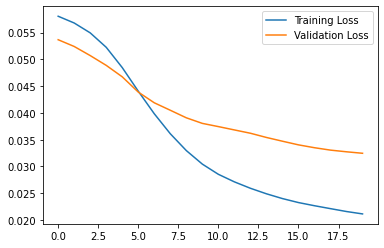

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

# convert to TF lite model

### export the saved model

In [16]:
export_dir = "anomaly_ecg"
tf.saved_model.save(autoencoder, export_dir)

INFO:tensorflow:Assets written to: anomaly_ecg\assets


## convert the model

In [17]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

## save the model

In [18]:
tflite_model_file = pathlib.Path('tflite_model.tflite')
tflite_model_file.write_bytes(tflite_model)

44456

### allocate tensors to TFLite model

In [19]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

### get input and output details

In [20]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
input_details

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 140]),
  'shape_signature': array([ -1, 140]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [22]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 19,
  'shape': array([  1, 140]),
  'shape_signature': array([ -1, 140]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

## convert intrepreter size for testing data

In [23]:
def testing_TFlite(testing_data):
    dim = np.shape(testing_data)
    interpreter.resize_tensor_input(input_details[0]['index'], dim)
    interpreter.resize_tensor_input(output_details[0]['index'], dim)
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'],testing_data)
    interpreter.invoke()
    predicted_data = interpreter.get_tensor(output_details[0]['index'])
    return(predicted_data)

# TF vs TFlite error on reconstructed data

### Reconstruction error on normal test data using TF

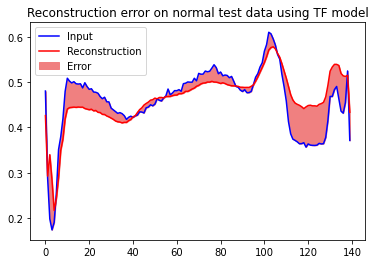

In [57]:
encoded_normal_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_normal_imgs = autoencoder.decoder(encoded_normal_imgs).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_normal_imgs[0], 'r')
plt.title('Reconstruction error on normal test data using TF model')
plt.fill_between(np.arange(140), decoded_normal_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Reconstruction error on anomalous test data using TF

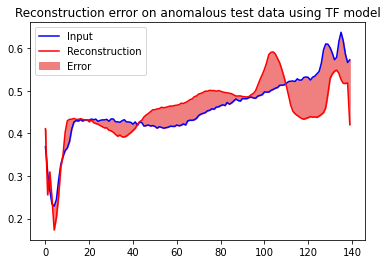

In [56]:
encoded_anomalous_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_anomalous_imgs = autoencoder.decoder(encoded_anomalous_imgs).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_anomalous_imgs[0], 'r')
plt.title('Reconstruction error on anomalous test data using TF model')
plt.fill_between(np.arange(140), decoded_anomalous_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Reconstruction error on normal test data using TFlite

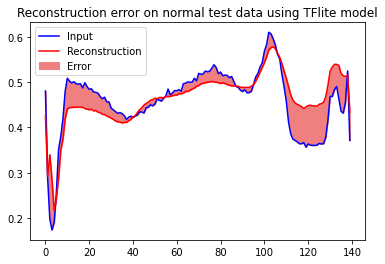

In [55]:
pred_normal_test = testing_TFlite(normal_test_data)

plt.plot(normal_test_data[0], 'b')
plt.plot(pred_normal_test[0], 'r')
plt.title('Reconstruction error on normal test data using TFlite model')
plt.fill_between(np.arange(140), pred_normal_test[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Reconstruction error on anomalous test data using TFlite

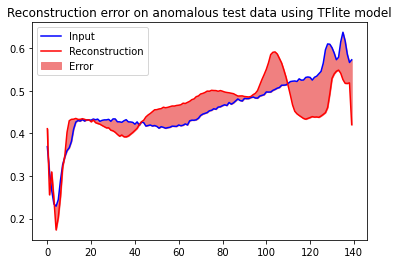

In [54]:
pred_anomalous_test = testing_TFlite(anomalous_test_data)

plt.plot(anomalous_test_data[0], 'b')
plt.plot(pred_anomalous_test[0], 'r')
plt.title('Reconstruction error on anomalous test data using TFlite model')
plt.fill_between(np.arange(140), pred_anomalous_test[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

# TF vs TFlite train loss

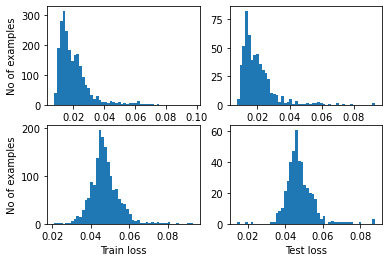

In [32]:
normal_train_pred = autoencoder.predict(normal_train_data)
train_loss_normal = tf.keras.losses.mae(normal_train_pred, normal_train_data)

plt.subplot(2, 2, 1)
plt.hist(train_loss_normal[None,:], bins=50)
#plt.xlabel("Train loss on normal train data")
plt.ylabel("No of examples")

normal_test_pred = autoencoder.predict(normal_test_data)
test_loss_normal = tf.keras.losses.mae(normal_test_pred, normal_test_data)

plt.subplot(2, 2, 2)
plt.hist(test_loss_normal[None,:], bins=50)
#plt.xlabel("Test loss on normal test data")
#plt.ylabel("No of examples")

anomalous_train_pred = autoencoder.predict(anomalous_train_data)
train_loss_anomalous = tf.keras.losses.mae(anomalous_train_pred, anomalous_train_data)

plt.subplot(2, 2, 3)
plt.hist(train_loss_anomalous[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")

anomalous_test_pred = autoencoder.predict(anomalous_test_data)
test_loss_anomalous = tf.keras.losses.mae(anomalous_test_pred, anomalous_test_data)

plt.subplot(2, 2, 4)
plt.hist(test_loss_anomalous[None,:], bins=50)
plt.xlabel("Test loss")
#plt.ylabel("No of examples")

plt.show()

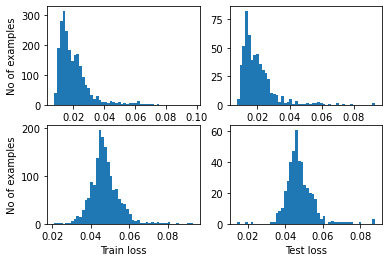

In [60]:
normal_train_pred_lite = testing_TFlite(normal_train_data)
train_loss_normal_lite  = tf.keras.losses.mae(normal_train_pred_lite , normal_train_data)

plt.subplot(2, 2, 1)
plt.hist(train_loss_normal_lite[None,:], bins=50)
#plt.xlabel("Train loss on normal train data")
plt.ylabel("No of examples")

normal_test_pred_lite  = testing_TFlite(normal_test_data)
test_loss_normal_lite  = tf.keras.losses.mae(normal_test_pred_lite , normal_test_data)

plt.subplot(2, 2, 2)
plt.hist(test_loss_normal_lite[None,:], bins=50)
#plt.xlabel("Test loss on normal test data")
#plt.ylabel("No of examples")

anomalous_train_pred_lite  = testing_TFlite(anomalous_train_data)
train_loss_anomalous_lite  = tf.keras.losses.mae(anomalous_train_pred_lite , anomalous_train_data)

plt.subplot(2, 2, 3)
plt.hist(train_loss_anomalous_lite[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")

anomalous_test_pred_lite  = testing_TFlite(anomalous_test_data)
test_loss_anomalous_lite  = tf.keras.losses.mae(anomalous_test_pred_lite , anomalous_test_data)

plt.subplot(2, 2, 4)
plt.hist(test_loss_anomalous_lite[None,:], bins=50)
plt.xlabel("Test loss")
#plt.ylabel("No of examples")

plt.show()

## set the threshold for train loss to be anomaly

### TF model threshold

In [64]:
tf_test_pred  = autoencoder.predict(test_data)
tf_test_loss = tf.keras.losses.mae(tf_test_pred , test_data)

threshold_tf = np.mean(tf_test_loss) + np.std(tf_test_loss)
print("Threshold for tf model : ", threshold_tf)

Threshold for tf model :  0.0490691


### TFlite model threshold

In [62]:
tflite_test_pred  = testing_TFlite(test_data)
tflite_test_loss = tf.keras.losses.mae(tflite_test_pred , test_data)

threshold_tflite = np.mean(tflite_test_loss) + np.std(tflite_test_loss)
print("Threshold for tflite model : ", threshold_tflite)

Threshold for tflite model :  0.0490691


## compare metrics for TF and TFlite models

In [82]:
def predict_tf(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def predict_tflite(data,threshold):
    reconstructions = testing_TFlite(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, preds)*100) + "%")
    print("Precision = {}".format(precision_score(labels, preds)))
    print("Recall = {}".format(recall_score(labels, preds)))

In [83]:
tf_preds = predict_tf(autoencoder, test_data, threshold_tf)
tflite_preds = predict_tflite(test_data, threshold_tflite)
print("Metrics for tf model\n")
print_stats(tf_preds, test_labels)
print(" ")
print("Metrics for tflite model\n")
print_stats(tflite_preds, test_labels)

Metrics for tf model

Accuracy = 94.3%
Precision = 0.9921722113502935
Recall = 0.9053571428571429
 
Metrics for tflite model

Accuracy = 94.3%
Precision = 0.9921722113502935
Recall = 0.9053571428571429
